## Importing required libraries

In [1]:
import sys 
sys.path.append('/home/aistudio/external-libraries')

import jax 
import jax.numpy as jnp
import optax
import jaxopt
from jax import device_put

jax.config.update("jax_enable_x64", True)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Data Loading and Generating

In [2]:
str_lags = "4_2"

real_lags = [float(x) for x in str_lags.split('_')]

# Load the dataset with the given real lag value
data = pd.read_csv(f'points_{str_lags}.csv')

# Extract given data points from the dataset and convert to JAX-compatible numpy array
init_data1 = jnp.array(data.iloc[:, [0, 1]].to_numpy())
init_data2 = jnp.array(data.iloc[:, [0, 2]].to_numpy())
init_data3 = jnp.array(data.iloc[:, [0, 3]].to_numpy())
init_data = [init_data1, init_data2, init_data3]

# conds represents the initial conditions S(0)=5, I(0)=1, R(0)=0.
conds = jnp.array([[0., 5., 1., 0.]], dtype=jnp.float64)

# Number of internal random points
N_f = 5000

# Range for sampling points
tmin, tmax = 0.0, 10.0

# Generate random points within the specified range
ik = 0
jaxKey = jax.random.PRNGKey(ik)
inPoints = jax.random.uniform(jaxKey, minval=tmin, maxval=tmax, shape=(N_f,1), dtype='float64')

## DNNs Model Definition and Parameter Initialization

In [3]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[:-1]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)
        
    w, b = params[-1]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    # Define lower and upper bounds for Xavier initialization
    lb, ub = -(1/jnp.sqrt(m)), (1/jnp.sqrt(n)) 

    w_key, b_key = jax.random.split(key)
    return lb + (ub-lb) * jax.random.uniform(w_key, (m, n)), jax.random.uniform(b_key, (n,))

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Defining the System of Delay Differential Equation
Consider the system of delay differential equations with two unknown delays on the solution interval $[0,10]$:
\begin{equation}
    \begin{cases}
        \begin{aligned}\dot{S}(t) &= -\beta \cdot S(t) \cdot I(t-\tau_2) + \gamma \cdot I(t-\tau_1), \quad t \geq 0, \\\dot{I}(t) &= \beta \cdot S(t) \cdot I(t-\tau_2) - \alpha \cdot  I(t), \quad t \geq 0, \\\dot{R}(t) &= \alpha \cdot I(t) - \gamma \cdot I(t-\tau_1), \quad t \geq 0.\end{aligned}
    \end{cases}
\end{equation}

The initial conditions are given by

\begin{equation}
    [S(0), I(0), R(0)] = [5, 1, 0].
\end{equation}

The system parameters are given by

\begin{equation}
    [\alpha, \beta, \gamma] = [0.3, 0.7, 0.1].
\end{equation}


In [4]:
def DDEs(t, u, lag):
    beta, alpha, gamma = 0.7, 0.3, 0.1

    S = u(t)[0]
    I = u(t)[1]
    R = u(t)[2]

    rhs = [-beta * S * jnp.where(t > lag[1], u(t - lag[1])[1], 1) + gamma * jnp.where(t > lag[0], u(t - lag[0])[1], 1),
            beta * S * jnp.where(t > lag[1], u(t - lag[1])[1], 1) - alpha * I,
            alpha * I - gamma * jnp.where(t > lag[0], u(t - lag[0])[1], 1)
    ]

    tem_list = []

    for i in range(3):
        u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)[i]))(t)
        tem_i = u_t(t) - rhs[i]
        tem_list.append(tem_i.reshape(-1, 1))

    tem = jnp.hstack(tem_list)
    
    return tem

## Define the loss function

In [5]:
@jax.jit
def loss_fun(params, inPoints, conds, init_data):
    lag = params[-1]
    t_f = inPoints[:,[0]]

    init_data1, init_data2, init_data3 = init_data[0], init_data[1], init_data[2]

    ufunc1 = lambda t: DNNs(params[0], t)
    ufunc2 = lambda t: DNNs(params[1], t)
    ufunc3 = lambda t: DNNs(params[2], t)

    def u(t):
        return [ufunc1(t), ufunc2(t), ufunc3(t)]

    # Calculate the loss due to the differential equation
    loss_f1 = jnp.mean((DDEs(t_f, u, lag)[:,0])**2)
    loss_f2 = jnp.mean((DDEs(t_f, u, lag)[:,1])**2)
    loss_f3 = jnp.mean((DDEs(t_f, u, lag)[:,2])**2)

    # Calculate the loss due to the initial conditions
    t_0, u1_0, u2_0, u3_0 = conds[:,[0]], conds[:,[1]], conds[:,[2]], conds[:,[3]]
    loss_i1 = jnp.mean((ufunc1(t_0)-u1_0)**2)
    loss_i2 = jnp.mean((ufunc2(t_0)-u2_0)**2)
    loss_i3 = jnp.mean((ufunc3(t_0)-u3_0)**2)

    # Calculate the loss due to known data points
    t_1, u_1 = init_data1[:, [0]], init_data1[:,[1]]
    loss_g1 = jnp.mean((u_1 - ufunc1(t_1))**2)

    t_2, u_2 = init_data2[:, [0]], init_data2[:,[1]]
    loss_g2 = jnp.mean((u_2 - ufunc2(t_2))**2)

    t_3, u_3 = init_data3[:, [0]], init_data3[:,[1]]
    loss_g3 = jnp.mean((u_3 - ufunc3(t_3))**2)

    # Compute the sum of loss from all components
    loss_sum = loss_f1 + loss_f2 + loss_f3 + loss_i1 + loss_i2 + loss_i3 + loss_g1 + loss_g2 + loss_g3

    # Calculate the weighted contribution of each loss component to the total loss
    w_f1 = loss_f1/loss_sum
    w_f2 = loss_f2/loss_sum
    w_f3 = loss_f3/loss_sum

    w_i1 = loss_i1/loss_sum
    w_i2 = loss_i2/loss_sum
    w_i3 = loss_i3/loss_sum

    w_g1 = loss_g1/loss_sum
    w_g2 = loss_g2/loss_sum
    w_g3 = loss_g3/loss_sum

    # Compute the weighted average of the losses to form the total loss
    loss_total = (
        w_f1 * loss_f1 + w_f2 * loss_f2 + w_f3 * loss_f3 +
        w_i1 * loss_i1 + w_i2 * loss_i2 + w_i3 * loss_i3 +
        w_g1 * loss_g1 + w_g2 * loss_g2 + w_g3 * loss_g3
    )

    return loss_total

## DNNs initialization

In [6]:
# Define the architecture of the neural network
netLayers = [1, 20, 40, 20, 1]

# Initialize network parameters using a predefined random key
key1 = jax.random.PRNGKey(ik)
params = [init_network_params(netLayers, key1)] * 3

# Append the parameter for the inverse problem (time delay 'lag1' and 'lag2') to the network parameters
lag_params = jnp.array([0., 0.], dtype=jnp.float64)
params.append(lag_params)

In [7]:
# Define the number of training epochs
epochs = 160001

# Lists to store the history of parameters and loss values during training
params_history = []
loss_history = []

# Define the ADAM optimizer with an exponential decay learning rate scheduler
scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=10000, decay_rate=0.9)
optimizer = optax.adam(learning_rate=scheduler)

# Initialize the optimizer state
opt_state = optimizer.init(params)

# Define the update function, decorated with 'jax.jit' for enhanced performance
@jax.jit
def update(params, opt_state, inPoints, conds, init_data):
    # Calculate loss and gradients
    loss, grads = jax.value_and_grad(loss_fun)(params, inPoints, conds, init_data)
    # Update parameters based on gradients
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Execute the training loop
for epoch in range(epochs):
    # Perform a single update step
    params, opt_state, loss = update(params, opt_state, inPoints, conds, init_data)
    # Append the last parameter set and the corresponding loss to their histories
    params_history.append(params[-1])
    loss_history.append(loss)
    # Output loss information every 2000 epochs
    if epoch % 2000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 2595.1868617802043
Epoch 2000, Loss: 0.09232562182155792
Epoch 4000, Loss: 0.0509951018755297
Epoch 6000, Loss: 0.023800047713525042
Epoch 8000, Loss: 0.011239981678799289
Epoch 10000, Loss: 0.003833398167435202
Epoch 12000, Loss: 0.0023310666191350984
Epoch 14000, Loss: 0.001790155782989551
Epoch 16000, Loss: 0.001708027212963571
Epoch 18000, Loss: 0.0014624655216974774
Epoch 20000, Loss: 0.00107728365502394
Epoch 22000, Loss: 0.0005451887585342692
Epoch 24000, Loss: 0.0003545686098123066
Epoch 26000, Loss: 0.00023621870204740294
Epoch 28000, Loss: 0.0002054534994795618
Epoch 30000, Loss: 0.00018482969547512903
Epoch 32000, Loss: 0.00014561304971929363
Epoch 34000, Loss: 0.00014016438401680782
Epoch 36000, Loss: 0.0002420650979461971
Epoch 38000, Loss: 0.0001178973758504197
Epoch 40000, Loss: 0.0008328095388972678
Epoch 42000, Loss: 9.791539639859921e-05
Epoch 44000, Loss: 8.663423969176638e-05
Epoch 46000, Loss: 8.20233893185202e-05
Epoch 48000, Loss: 7.597852421665443

## Calculating Relative Error

In [8]:
for i in range(len(params[-1])):
    error = abs(params[-1][i] - real_lags[i])
    print(params[-1][i])
    print(error/real_lags[i])
    print("-------------------")


4.000208060858543
5.201521463571446e-05
-------------------
1.9587039706993152
0.020648014650342383
-------------------


## Result visualization

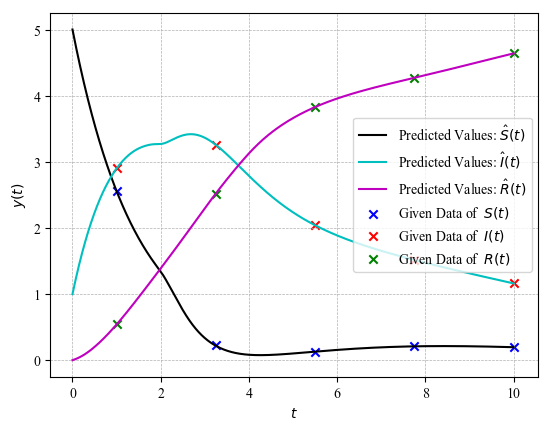

In [13]:
# Generate a set of 10,000 evenly spaced time points between tmin and tmax
T = np.linspace(tmin, tmax, 10000).reshape(-1,1) 

# Evaluate the neural network for three sets of parameters to get predictions for each set
nn_sol1 = DNNs(params[0],T.reshape(-1,1))
nn_sol2 = DNNs(params[1],T.reshape(-1,1))
nn_sol3 = DNNs(params[2],T.reshape(-1,1))

# Extract time points and real values from the data for three different series
t_points = data.iloc[:,0]
y1_real = data.iloc[:,1]
y2_real = data.iloc[:,2]
y3_real = data.iloc[:,3]

# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot real and predicted values for three series using different styles and colors
plt.scatter(t_points, y1_real, label='Given Data of  $S(t)$', color='blue', marker='x')
plt.scatter(t_points, y2_real, label='Given Data of  $I(t)$', color='red', marker='x')
plt.scatter(t_points, y3_real, label='Given Data of  $R(t)$', color='green', marker='x')

plt.plot(T,nn_sol1,'k',label='Predicted Values: $\hat{S}(t)$')
plt.plot(T,nn_sol2,'c',label='Predicted Values: $\hat{I}(t)$')
plt.plot(T,nn_sol3,'m',label='Predicted Values: $\hat{R}(t)$')

# Add a legend with font properties
plt.legend(prop=prop)

# Set labels for the x and y axes with font properties
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y(t)$', fontproperties=prop)

# Customize the appearance of the axis tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Optionally save the figure with high resolution
# Uncomment the next line to save the figure
# plt.savefig(f'/home/aistudio/work/NDDEs_for_the_system_of_DDEs/Inverse_Problem/ex1/{str_lags}/DDEs_IP_ex1_{str_lags}.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

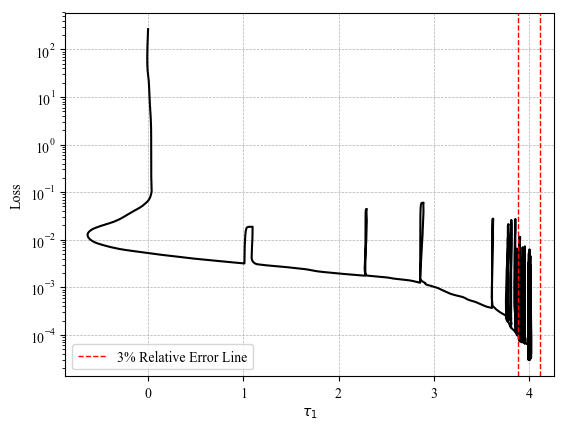

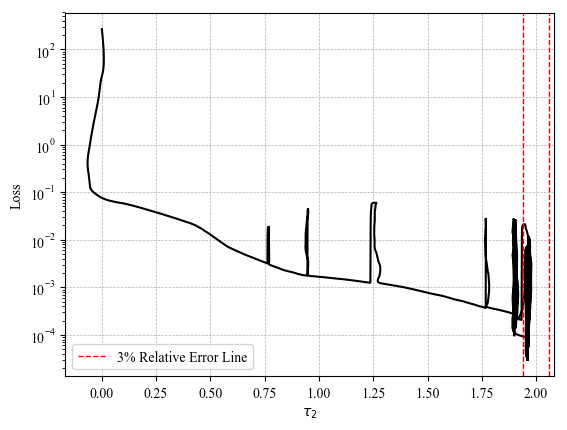

In [14]:
lags_data = [[float(x) for x in tup] for tup in params_history]
df_ = pd.DataFrame(lags_data, columns=['lag1', 'lag2'])

# Define a function to compute the moving average of data
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Define a function to compute relative error bounds
def relative_error_lines(real_value, error_percentage):
    lower_bound = real_value * (1 - error_percentage / 100)
    upper_bound = real_value * (1 + error_percentage / 100)
    return lower_bound, upper_bound, error_percentage

# Set the size of the moving average window
window_size = 100

for i in range(2):
    smoothed_loss_history = moving_average(loss_history, window_size)
    smoothed_params_history = df_.iloc[:len(smoothed_loss_history),i]

    # Calculate error bounds for the given real_lag with a 3% error margin
    lower_bound, upper_bound, error_percentage = relative_error_lines(real_lags[i], 3)

    # Set the figure size in a 4:3 aspect ratio
    plt.figure(figsize=(16 / 2.54, 12 / 2.54))

    # Plot the smoothed curve
    plt.plot(smoothed_params_history, smoothed_loss_history, 'k')

    # Draw vertical lines representing the 3% error range
    plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1, label=f'{error_percentage}% Relative Error Line')
    plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

    # Set the y-axis to logarithmic scale for better visualization of differences
    plt.yscale('log')

    # Add labels to the axes
    plt.xlabel(f'$\\tau_{i+1}$', fontproperties=prop)
    plt.ylabel('Loss', fontproperties=prop)

    # Customize the tick labels using font properties
    ax = plt.gca()
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(prop)

    # Add grid lines, major only, with specific style
    plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

    # Display the legend with custom font properties
    plt.legend(prop=prop)

    # Save the figure with high resolution
    # plt.savefig(f'/home/aistudio/work/NDDEs_for_the_system_of_DDEs/Inverse_Problem/ex1/{str_lags}/DDEs_IP_ex1_{str_lags}_loss{i+1}.png', dpi=600, bbox_inches='tight')
    
    # Display the plot
    plt.show()